In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize_scalar

from abc import ABC, abstractmethod
from itertools import product
from sklearn.metrics.cluster import rand_score
from sklearn.cluster import KMeans

from scipy.optimize import fsolve
from scipy.stats import lognorm

In [4]:
class betaWSBM:
	def __init__(self, n, rho, Pi, Alpha):
		# n: number of nodes
		# rho: probability of observing a link
		# Pi: probabilities for community membership
		# Alpha: shape parameters for the beta distribution
		self.n = n
		self.rho = rho
		self.Pi = Pi
		self.Alpha = Alpha

	def __call__(self):
		# Simulates the weighted stochastic block model.
		# Returns the adjacency matrix and community labels.
		Z = np.random.choice([0, 1], size=self.n, p=np.diag(Pi))  # Generate community labels
		A = np.ones((self.n, self.n))  # Initialize the adjacency matrix with ones
		mask = np.random.rand(self.n, self.n) < self.rho  # Create a mask for observed entries
		
		# Fill in the masked entries with beta-distributed random values.
		A[mask] = stats.beta.rvs(self.Alpha[Z[:, None], Z[None, :]][mask], 1)
		A = np.triu(A) + np.triu(A, 1).T  # Make the matrix symmetric
		np.fill_diagonal(A, 0)
		return A, Z
	
class lognormWSBM:
	def __init__(self, n, rho, Pi, S, Scale):
		# n: number of nodes
		# rho: probability of observing a link
		# Pi: probabilities for community membership
		# S: shape parameter for the lognormal distribution
		# Scale: scale parameter for the lognormal distribution
		self.n = n
		self.rho = rho
		self.Pi = Pi
		self.S = S
		self.Scale = Scale

	def __call__(self):
		# Simulates the weighted stochastic block model.
		# Returns the adjacency matrix and community labels.
		Z = np.random.choice([0, 1], size=self.n, p=np.diag(Pi))  # Generate community labels
		A = np.ones((self.n, self.n))  # Initialize the adjacency matrix with ones
		mask = np.random.rand(self.n, self.n) < self.rho  # Create a mask for observed entries
		
		# Fill in the masked entries with lognormal-distributed random values.
		A[mask] = stats.lognorm.rvs(s=self.S[Z[:, None], Z[None, :]][mask],
									scale=self.Scale[Z[:, None], Z[None, :]][mask])
		A = np.triu(A) + np.triu(A, 1).T  # Make the matrix symmetric
		np.fill_diagonal(A, 0)
		return A, Z

In [ ]:
# Abstract class for weight transformations
class WeightTransform(ABC):
	@abstractmethod
	def __call__(self, A):
		# Apply the transformation to matrix A.
		pass

	@abstractmethod
	def second_order_stats(self, Alpha, rho):
		# Calculate the theoretical mean and covariance according to the transformation.
		pass

# Opposite transformation (1 - A)
class OppositeTransform(WeightTransform):
	def __call__(self, A):
		A = 1 - A
		np.fill_diagonal(A, 0)
		return A

	def second_order_stats(self, Alpha, rho):
		B = rho * Alpha / (Alpha + 1.0)
		C = rho * Alpha / (Alpha + 2.0) - B**2
		return B, C

# Logarithmic transformation (-log(A))
class LogTransform(WeightTransform):
	def __call__(self, A):
		A = -np.log(A)
		np.fill_diagonal(A, 0)
		return A

	def second_order_stats(self, Alpha, rho):
		B = rho / Alpha
		C = rho * (2.0 / Alpha**2) - B**2
		return B, C

# Threshold transformation (binary thresholding)
class ThresholdTransform(WeightTransform):
	def __init__(self, threshold):
		self.threshold = threshold

	def __call__(self, A):
		A = (A <= self.threshold).astype(float)
		np.fill_diagonal(A, 0)
		return A

	def second_order_stats(self, Alpha, rho):
		B = rho * (self.threshold ** Alpha)
		C = B * (1 - B)
		return B, C

# Identity transformation (no changes to A)
class IdentityTransform(WeightTransform):
	def __call__(self, A):
		return A

	def second_order_stats(self, Alpha, rho):
		B = 1 - rho / (Alpha + 1.0)
		C = 1 - (2 * rho / (Alpha + 2.0)) - B**2
		return B, C

# Rank transformation (normalized ranking of upper-triangular values)
class RankTransform(WeightTransform):
	def __call__(self, A):
		n = A.shape[0]
		N = n * (n - 1) // 2

		# Extract upper triangular values
		iu = np.triu_indices(n, k=1)
		upper_vals = A[iu]

		# Compute normalized ranks
		normalized_ranks = (np.argsort(np.argsort(upper_vals)) + 1) / float(N + 1)

		# Create output matrix
		R = np.zeros_like(A, dtype=float)
		R[iu] = normalized_ranks
		R = R + R.T
		
		return R
	
	def second_order_stats(self, Alpha, rho):
		return None, None

# Compute empirical mean and variance per block
def empirical_block_stats(A, Z, K):
	B, C = np.zeros((K, K)), np.zeros((K, K))

	for k, l in product(range(K), repeat=2):
		# Select block values using boolean masking
		block_values = A[np.ix_(Z == k, Z == l)].ravel()

		if block_values.size:
			B[k, l] = block_values.mean()
			C[k, l] = block_values.var(ddof=1)

	return B, C

# Compute size-adjusted Chernoff information
def size_adjusted_chernoff_information(B, C, Pi):
	# Computes the size-adjusted Chernoff information for a K-community stochastic block model.
	# Assumes rank(B) = K.
	
	# Parameters:
	# B : numpy.ndarray (K x K) - Mean block matrix
	# C : numpy.ndarray (K x K) - Block variance matrix
	# Pi : numpy.ndarray (K x K) - Block probability matrix
	
	# Returns:
	# float - The size-adjusted Chernoff information
	
	K = B.shape[0]
	E = np.eye(K)  # Standard basis vectors

	def objective(t, k, l):
		# Computes the quadratic form associated with Chernoff information
		S_kl_t = (1 - t) * np.diag(C[k]) + t * np.diag(C[l])
		ek_el = (E[k] - E[l])[:, None]
		val = ek_el.T @ B @ Pi @ np.linalg.inv(S_kl_t) @ B @ ek_el
		return 0.5 * t * (1 - t) * val.item()
	
	def neg_objective(t, k, l):
		return -objective(t, k, l)
	
	best_value = np.inf
	
	for k_ in range(K):
		for l_ in range(K):
			if k_ == l_:
				continue
			res = minimize_scalar(neg_objective, bounds=(0, 1), method='bounded', args=(k_, l_))
			max_val = -res.fun
			best_value = min(best_value, max_val)
	
	return best_value

# Compute spectral embedding
def spectral_embedding(A, d=2):
	# Computes spectral embedding using top-d eigenvectors
	vals, vecs = eigsh(A, k=d, which='LM')
	return vecs * np.sqrt(np.abs(vals))  # Projection using eigenvalues

def fit_GMM(X):
	gmm = GaussianMixture(n_components=2, covariance_type='full').fit(X)
	return gmm.predict(X), gmm.means_, gmm.covariances_

def fit_KMeans(X):
	kmeans = KMeans(n_clusters=2, random_state=42).fit(X)
	return kmeans.labels_

In [6]:
# Fix seed for reproducibility
np.random.seed(42)

n = 1000  # Number of nodes

pi1 = 0.1  # Proportion of anomalous nodes
Pi = np.diag([pi1, 1 - pi1])

rho = 0.25  # Edge probability

Alpha = np.array([[0.1, 1.0],
				  [1.0, 1.0]])

threshold = 0.1

In [37]:
S = np.array([[1, 0.5],
			  [0.5, 1]])
Scale = np.array([[1, 1],
				[1, 1]])

In [38]:
identitytransform = IdentityTransform()
oppositetransform = OppositeTransform()
logtransform = LogTransform()
thresholdtransform = ThresholdTransform(threshold)

beta_A, beta_Z = betaWSBM(n, rho, Pi, Alpha)()

beta_Ai = identitytransform(beta_A)
beta_Ao = oppositetransform(beta_A)
beta_Al = logtransform(beta_A)
beta_At = thresholdtransform(beta_A)

lognorm_A, lognorm_Z = lognormWSBM(n, rho, Pi, S, Scale)()

lognorm_Ai = identitytransform(lognorm_A)
lognorm_Ao = oppositetransform(lognorm_A)
lognorm_Al = logtransform(lognorm_A)
lognorm_At = thresholdtransform(lognorm_A)

C:\Users\Nicol\AppData\Local\Temp\ipykernel_10404\57856061.py:28: RuntimeWarning: divide by zero encountered in log
  A = -np.log(A)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot(A, Z, title):
    B_hat, C_hat = empirical_block_stats(A, Z, 2)
    chernoff = size_adjusted_chernoff_information(B_hat, C_hat, Pi)
    X = spectral_embedding(A)
    labels_GMM, means_GMM, cov_GMM = fit_GMM(X)
    rand_GMM = rand_score(Z, labels_GMM)
    labels_KMeans = fit_KMeans(X)
    rand_KMeans = rand_score(Z, labels_KMeans)

    _, axes = plt.subplots(1, 3, figsize=(15, 5))

    # True communities
    plt.sca(axes[0])
    plt.scatter(X[:, 0], X[:, 1], c=Z, cmap='bwr', marker='.', alpha=0.2)
    plt.title(f'{title} - True Communities\n Empirical Chernoff: {chernoff:.5f}')
    plt.grid(True)

    # GMM clustering
    plt.sca(axes[1])
    plt.scatter(X[:, 0], X[:, 1], c=labels_GMM, cmap='bwr', marker='.', alpha=0.2)
    for mean, cov in zip(means_GMM, cov_GMM):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        angle = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
        angle = np.degrees(angle)
        width, height = 2 * np.sqrt(6 * eigenvalues)
        ellip = plt.matplotlib.patches.Ellipse(
            mean, width, height, angle=angle, edgecolor='k', facecolor='none', linestyle='dashed')
        plt.gca().add_patch(ellip)
    plt.title(f'{title} - GMM\nRand Score: {rand_GMM:.2f}')
    plt.grid(True)

    # KMeans clustering
    plt.sca(axes[2])
    plt.scatter(X[:, 0], X[:, 1], c=labels_KMeans, cmap='bwr', marker='.', alpha=0.2)
    plt.title(f'{title} - KMeans\nRand Score: {rand_KMeans:.2f}')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

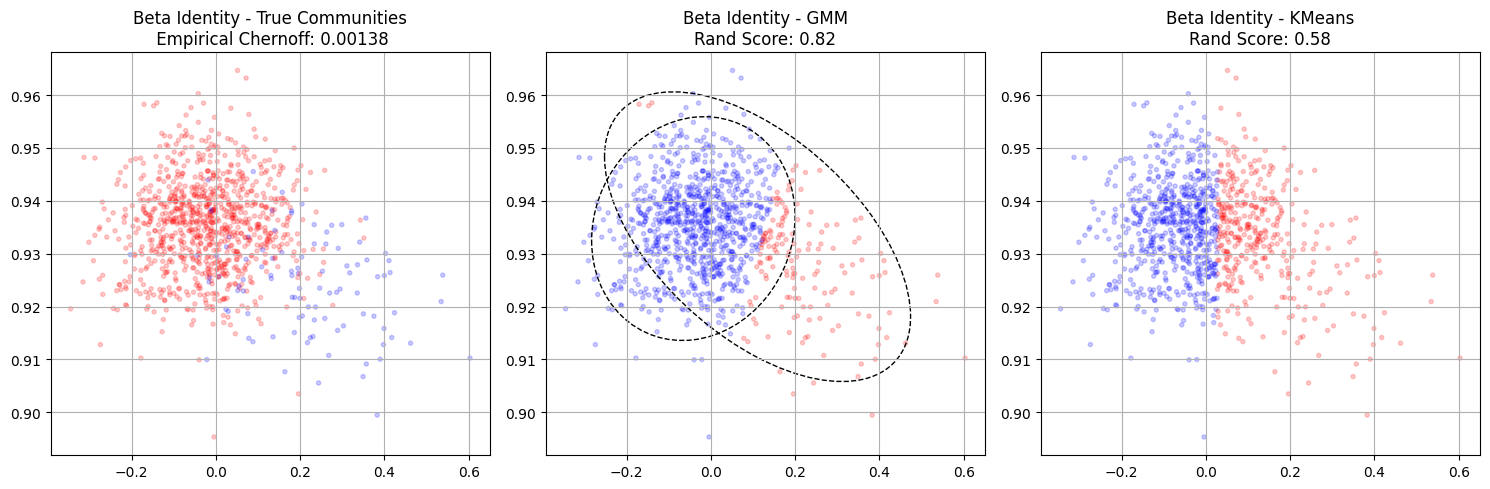

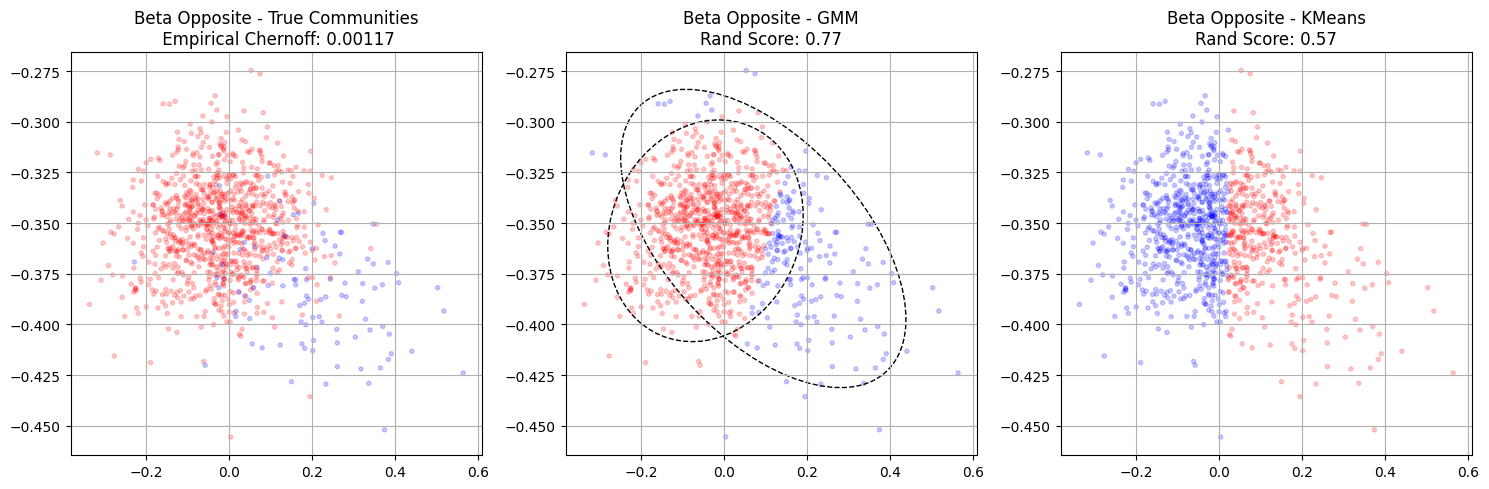

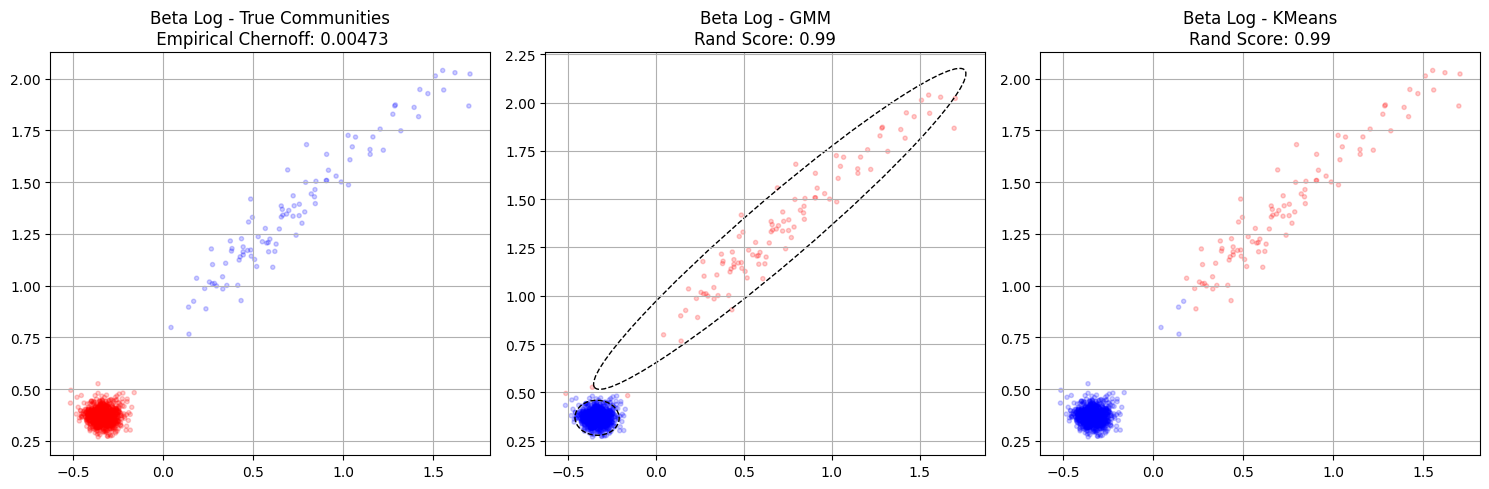

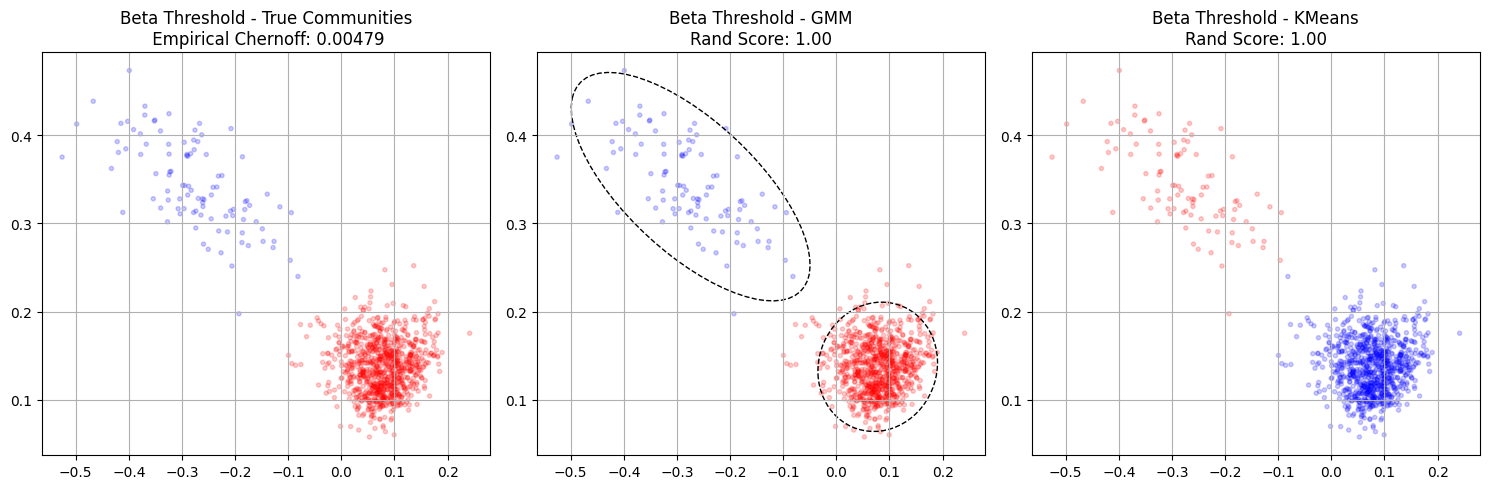

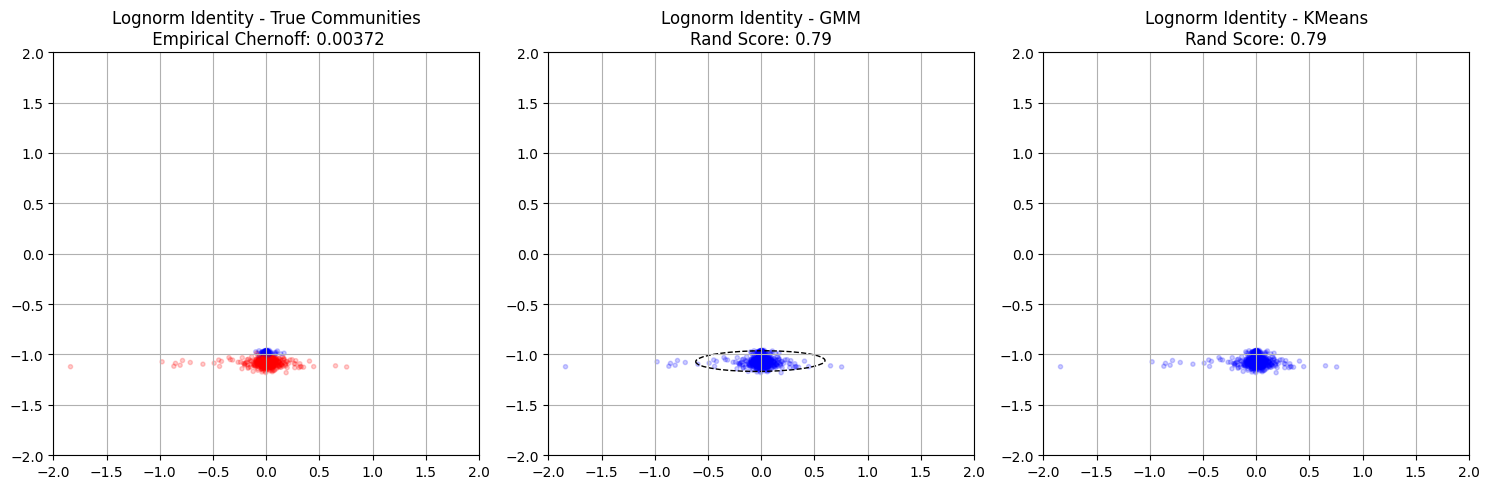

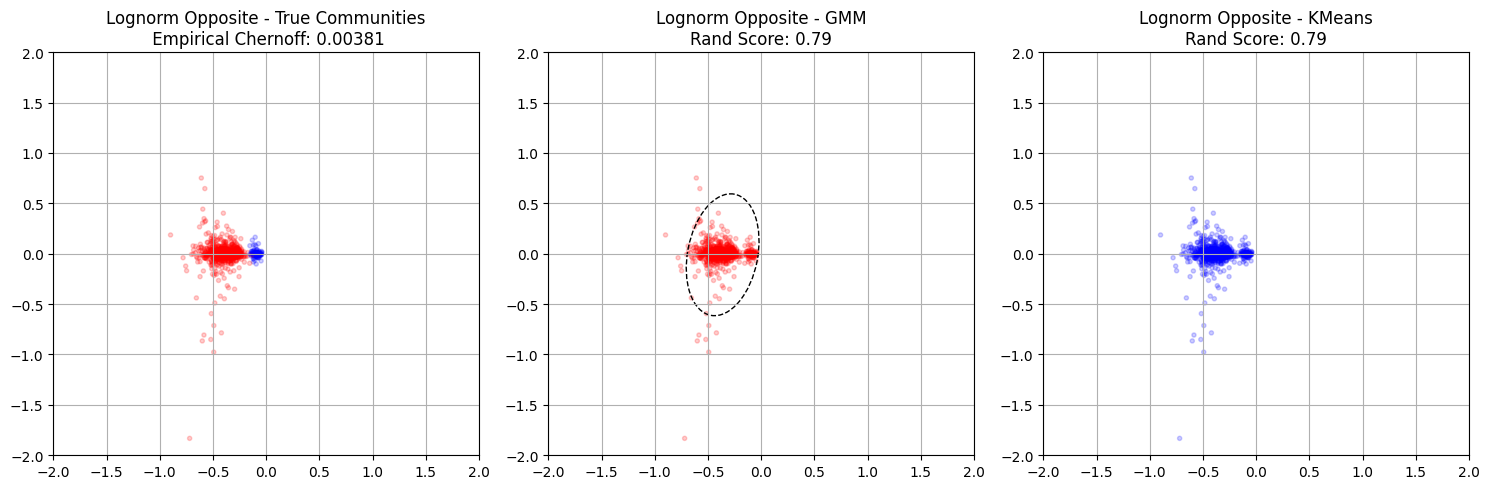

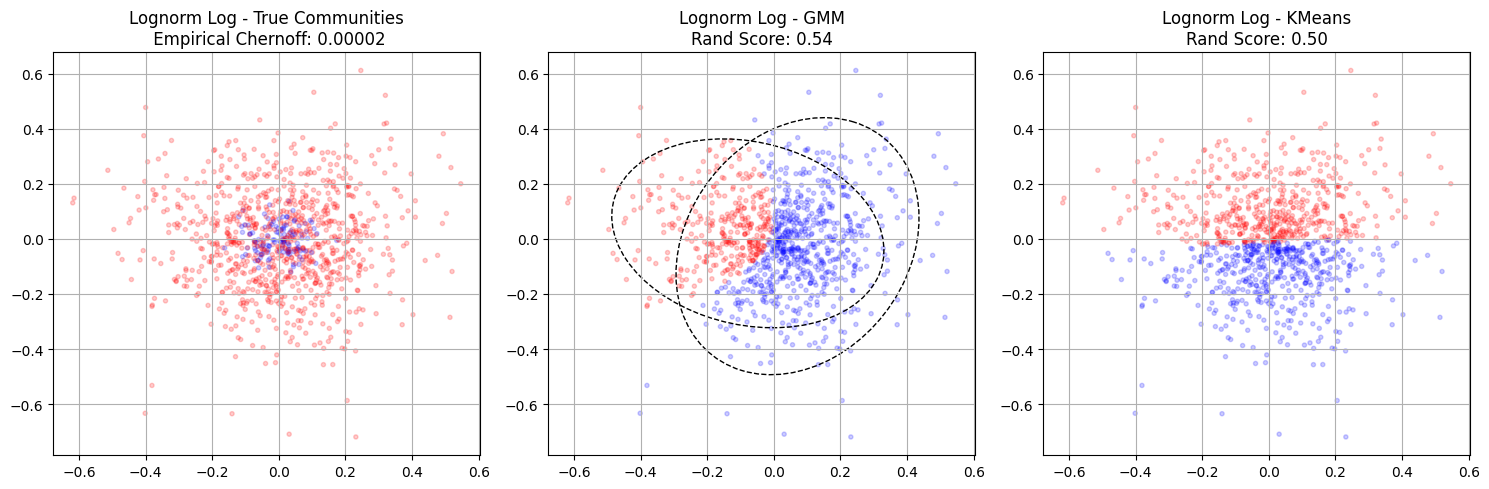

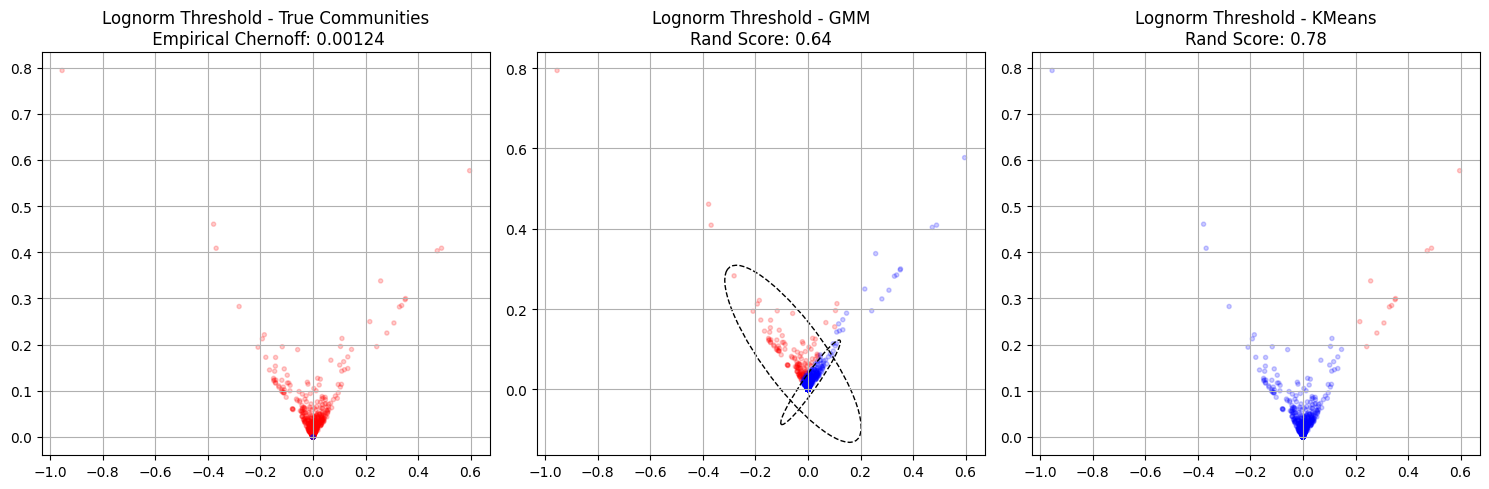

In [39]:
plot(beta_Ai, beta_Z, 'Beta Identity')
plot(beta_Ao, beta_Z, 'Beta Opposite')
plot(beta_Al, beta_Z, 'Beta Log')
plot(beta_At, beta_Z, 'Beta Threshold')

plot(lognorm_Ai, lognorm_Z, 'Lognorm Identity', (-2, 2), (-2, 2))
plot(lognorm_Ao, lognorm_Z, 'Lognorm Opposite', (-2, 2), (-2, 2))
plot(lognorm_Al, lognorm_Z, 'Lognorm Log')
plot(lognorm_At, lognorm_Z, 'Lognorm Threshold')

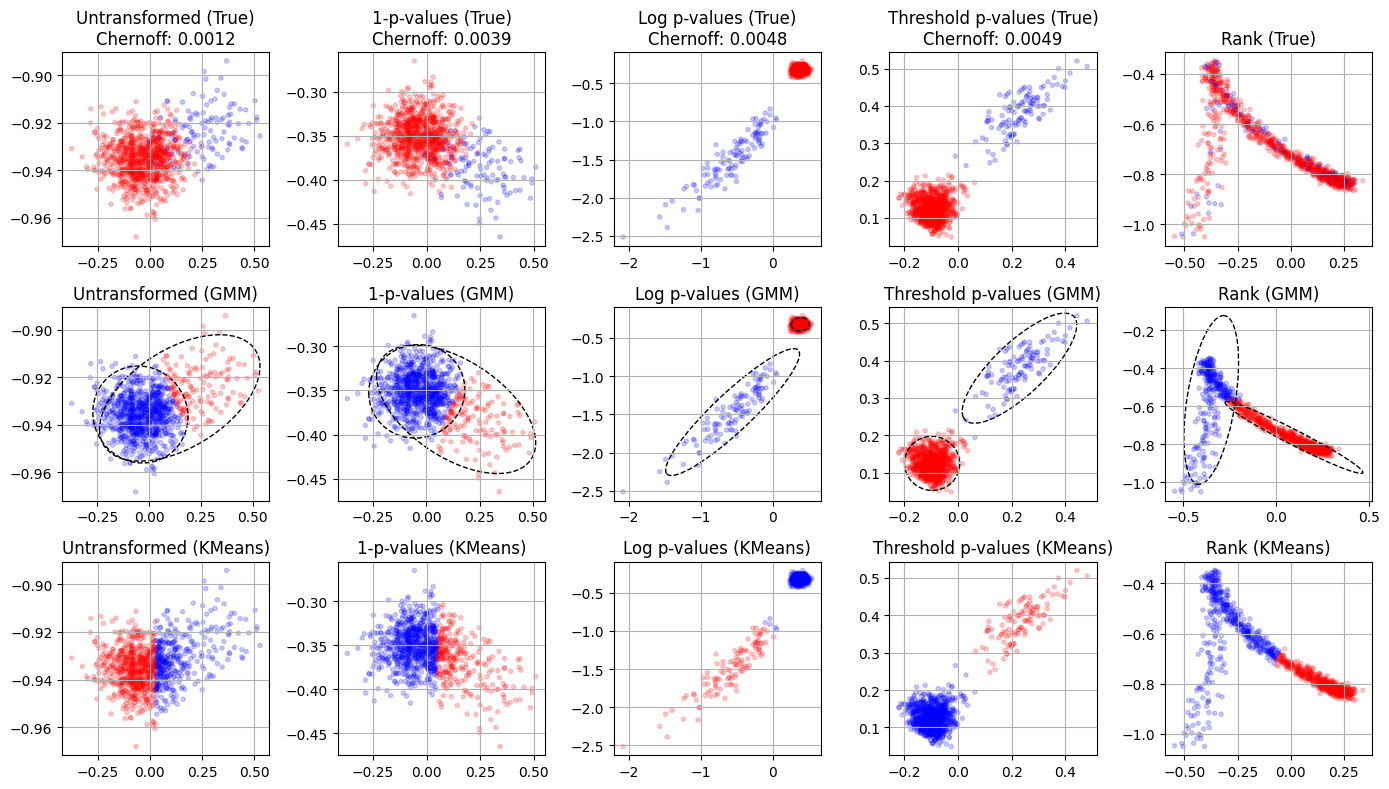

In [ ]:
# Function to plot embeddings with ellipses
def plot_embedding(X, labels, title, means=None, covs=None, chernoff_value=None):
	plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='bwr', marker='.', alpha=0.2)
	if means is not None and covs is not None:
		for mean, cov in zip(means, covs):
			eigenvalues, eigenvectors = np.linalg.eigh(cov)
			angle = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
			angle = np.degrees(angle)
			width, height = 2 * np.sqrt(6 * eigenvalues)
			ellip = plt.matplotlib.patches.Ellipse(
				mean, width, height, angle=angle, edgecolor='k', facecolor='none', linestyle='dashed')
			plt.gca().add_patch(ellip)
	c = '' if chernoff_value is None else f'\nChernoff: {chernoff_value:.4f}'
	plt.title(f"{title}{c}")
	plt.grid(True)

# Plot results
fig, axes = plt.subplots(3, 5, figsize=(14, 8))
plt.sca(axes[0][0])
plot_embedding(Xi, Z, 'Untransformed (True)', chernoff_value=chernoff_i)
plt.sca(axes[0][1])
plot_embedding(Xo, Z, '1-p-values (True)', chernoff_value=chernoff_o)
plt.sca(axes[0][2])
plot_embedding(Xl, Z, 'Log p-values (True)', chernoff_value=chernoff_l)
plt.sca(axes[0][3])
plot_embedding(Xt, Z, 'Threshold p-values (True)', chernoff_value=chernoff_t)
plt.sca(axes[0][4])
plot_embedding(Xr, Z, 'Rank (True)')
plt.sca(axes[1][0])
plot_embedding(Xi, labels_i_GMM, 'Untransformed (GMM)', means_i_GMM, cov_i_GMM)
plt.sca(axes[1][1])
plot_embedding(Xo, 1 - labels_o_GMM, '1-p-values (GMM)', means_o_GMM, cov_o_GMM)
plt.sca(axes[1][2])
plot_embedding(Xl, 1 - labels_l_GMM, 'Log p-values (GMM)', means_l_GMM, cov_l_GMM)
plt.sca(axes[1][3])
plot_embedding(Xt, 1 - labels_t_GMM, 'Threshold p-values (GMM)', means_t_GMM, cov_t_GMM)
plt.sca(axes[1][4])
plot_embedding(Xr, 1 - labels_r_GMM, 'Rank (GMM)', means_r_GMM, cov_r_GMM)
plt.sca(axes[2][0])
plot_embedding(Xi, labels_i_KMeans, 'Untransformed (KMeans)')
plt.sca(axes[2][1])
plot_embedding(Xo, labels_o_KMeans, '1-p-values (KMeans)')
plt.sca(axes[2][2])
plot_embedding(Xl, labels_l_KMeans, 'Log p-values (KMeans)')
plt.sca(axes[2][3])
plot_embedding(Xt, labels_t_KMeans, 'Threshold p-values (KMeans)')
plt.sca(axes[2][4])
plot_embedding(Xr, labels_r_KMeans, 'Rank (KMeans)')

plt.tight_layout()
plt.show()

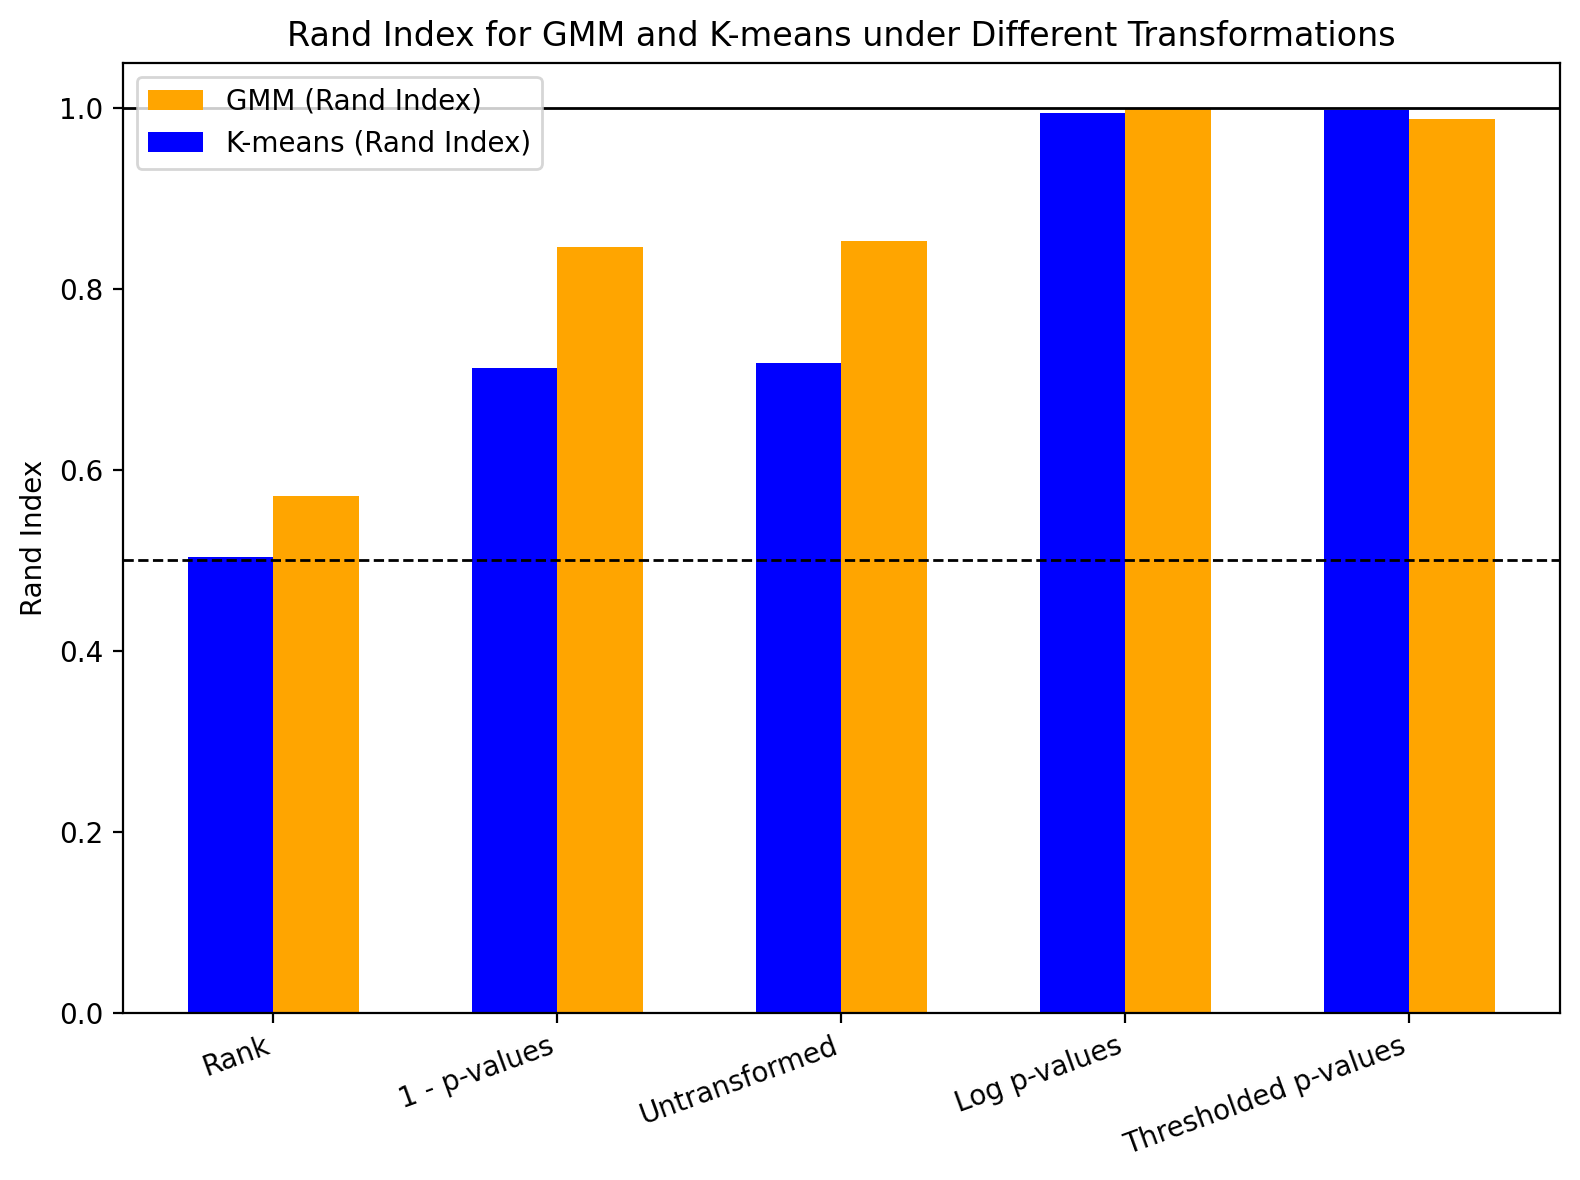

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# rand_score is available in scikit-learn 1.1+
# For older versions, you can use adjusted_rand_score instead, but it is not the same as the raw Rand index.
from sklearn.metrics.cluster import rand_score


transformations = [
	("Rank", labels_r_GMM, labels_r_KMeans),
	("1 - p-values", labels_o_GMM, labels_o_KMeans),
	("Untransformed", labels_i_GMM, labels_i_KMeans),
	("Log p-values", labels_l_GMM, labels_l_KMeans),
	("Thresholded p-values", labels_t_GMM, labels_t_KMeans)
]

# Collect Rand index values for plotting
rand_gmm_list = []
rand_kmeans_list = []
names_list = []

for name, labels_gmm, labels_kmeans in transformations:
	rand_gmm = rand_score(Z, labels_gmm)
	rand_kmeans = rand_score(Z, labels_kmeans)
	rand_gmm_list.append(rand_gmm)
	rand_kmeans_list.append(rand_kmeans)
	names_list.append(name)

# Create a bar chart
x = np.arange(len(names_list))  # positions for each transformation
width = 0.3

plt.figure(figsize=(8, 6), dpi=200)

# Plot GMM bars in orange
plt.bar(
	x + width/2, rand_gmm_list, width,
	color='orange', label='GMM (Rand Index)'
)

# Plot K-means bars in blue
plt.bar(
	x - width/2, rand_kmeans_list, width,
	color='blue', label='K-means (Rand Index)'
)

# Add horizontal lines at y = 1 and y = 0.5
plt.axhline(y=1, color='black', linestyle='-', linewidth=1)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)

# Labeling and formatting
plt.xticks(x, names_list, rotation=20, ha='right')  # rotate names if they're long
plt.ylim(0, 1.05)  # Rand index is between 0 and 1
plt.ylabel('Rand Index')
plt.title('Rand Index for GMM and K-means under Different Transformations')
plt.legend()
plt.tight_layout()
plt.show()

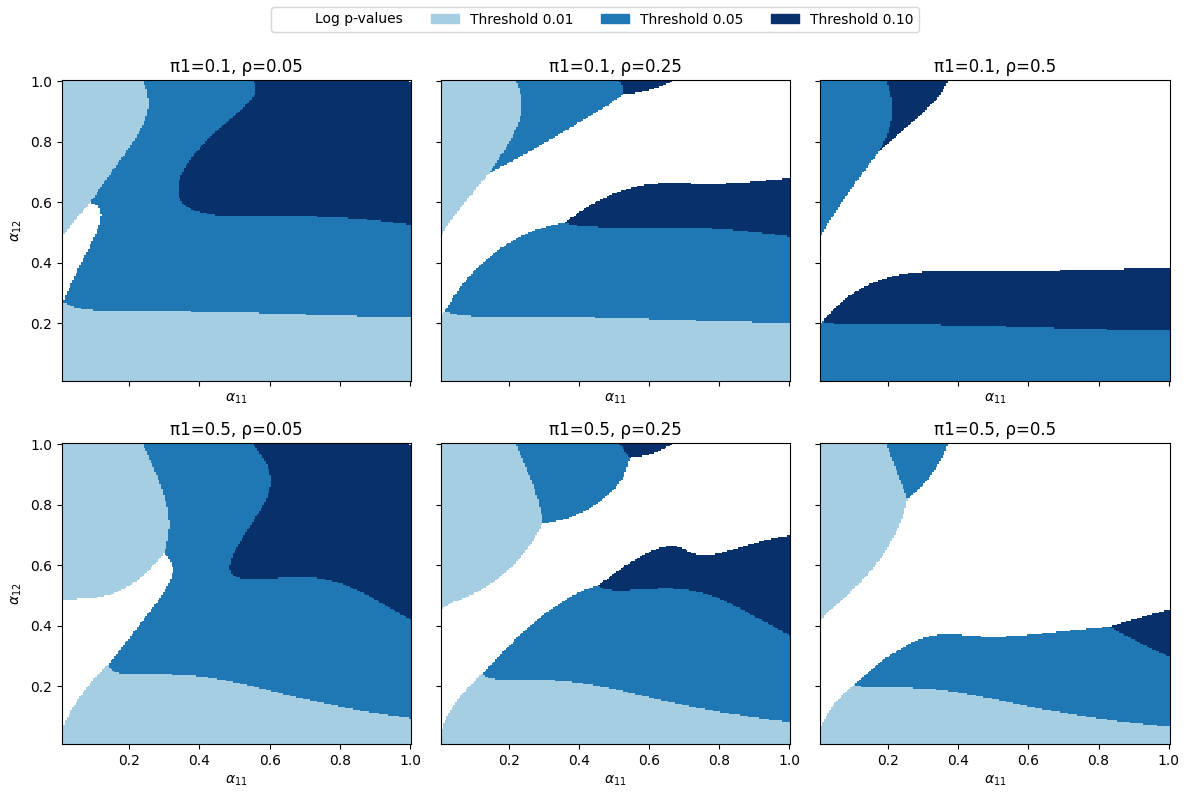

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# Set up the parameters for the figure
# ============================================================================
pi1_list = [0.1, 0.5]
rho_list = [0.05, 0.25, 0.50]
alpha_vals = np.linspace(0.01, 1, 200)  # grid of alpha11 or alpha12

# We will compare: "log p-values" vs. "threshold p-values" for thresholds 0.01, 0.05, 0.10.
threshold_candidates = [0.01, 0.05, 0.10]
n_alpha = len(alpha_vals)

# ============================================================================
# Prepare the figure
# ============================================================================
fig, axes = plt.subplots(
	nrows=2, ncols=3, figsize=(12, 8), sharex=True, sharey=True
)

for row_idx, pi1 in enumerate(pi1_list):
	for col_idx, rho in enumerate(rho_list):
		ax = axes[row_idx, col_idx]

		# We'll store an integer code at each grid point:
		#   0 -> "log p-values" is best
		#   1 -> threshold=0.01 is best
		#   2 -> threshold=0.05 is best
		#   3 -> threshold=0.10 is best
		best_choice_grid = np.zeros((n_alpha, n_alpha), dtype=int)

		# Compute, for each (alpha11, alpha12) in the grid,
		# which representation yields the greatest Chernoff info
		for i, a11 in enumerate(alpha_vals):
			for j, a12 in enumerate(alpha_vals):
				# Chernoff info for log p-values
				
				Alpha = np.array([[a11, a12], [a12, alpha22]])
				Pi = np.diag([pi1, 1 - pi1])
				Bl, Cl = logtransform.second_order_stats(Alpha, rho)
				ci_log = size_adjusted_chernoff_information(Bl, Cl, Pi)
			
				ci_thresholds = []
			
				for tau in threshold_candidates:
					thresholdtransform = ThresholdTransform(tau)
					Bt, Ct = thresholdtransform.second_order_stats(Alpha, rho)
					ci_thresholds.append(size_adjusted_chernoff_information(Bt, Ct, Pi))
			
				# Compare
				all_cis = [ci_log] + ci_thresholds
				best_idx = np.argmax(all_cis)  # returns index 0..3
				best_choice_grid[j, i] = best_idx

		# Now we create a color map:
		# White (index 0) -> log p-values
		# and 3 shades of blue for threshold p-values at 0.01, 0.05, 0.10
		from matplotlib.colors import ListedColormap
		cmap = ListedColormap(["white", "#A6CEE3", "#1F78B4", "#08306B"])

		# Plot using pcolormesh or imshow.  We need to invert j for y-axis if desired.
		# Here we just do pcolormesh, with alpha11 on x-axis, alpha12 on y-axis.
		X, Y = np.meshgrid(alpha_vals, alpha_vals)
		cax = ax.pcolormesh(X, Y, best_choice_grid, cmap=cmap, shading="auto")

		ax.set_title(f"π1={pi1}, ρ={rho}")
		ax.set_xlabel(r"$\alpha_{11}$")
		if col_idx == 0:
			ax.set_ylabel(r"$\alpha_{12}$")

# Adjust spacing and add a legend that matches the color coding
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create a separate color legend for clarity:
import matplotlib.patches as mpatches
legend_handles = [
	mpatches.Patch(color="white", label="Log p-values"),
	mpatches.Patch(color="#A6CEE3", label="Threshold 0.01"),
	mpatches.Patch(color="#1F78B4", label="Threshold 0.05"),
	mpatches.Patch(color="#08306B", label="Threshold 0.10"),
]
fig.legend(handles=legend_handles, loc="upper center", ncol=4)

plt.show()

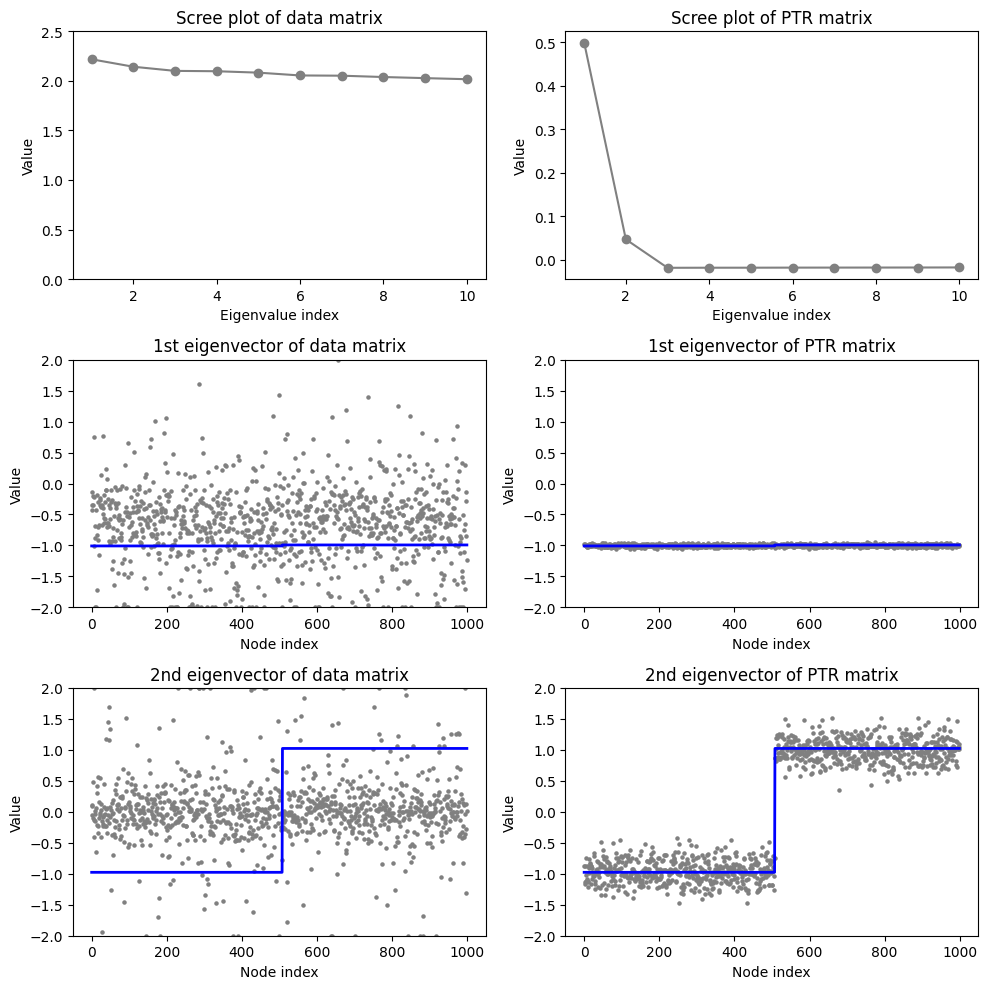

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

###############################################################################
# 1) Concise generator for a 2-block contaminated-normal matrix, A
###############################################################################
class ContaminatedNormal2Block:
	"""
	Generates an (n x n) contaminated-normal matrix for a 2-block model:
	  - With probability (1 - eps), entries come from Normal(mu[block_i, block_j], sigma[block_i, block_j]^2)
	  - With probability eps,   entries come from Normal(mu[block_i, block_j], (100*sigma[block_i, block_j])^2)
	The matrix is symmetric with zero diagonal.
	"""

	def __init__(self, n, eps, mu, sigma, block_probs=(0.5, 0.5), reorder=True):
		"""
		n           : total number of nodes
		eps         : contamination probability
		mu          : 2x2 array of means for each block pair
		sigma       : 2x2 array of stdevs for each block pair
		block_probs : probability of being in block 1 or block 2 (must sum to 1)
		reorder     : if True, reorder nodes so block 1 is first half, block 2 second half
		"""
		self.n = n
		self.eps = eps
		self.mu = mu
		self.sigma = sigma
		self.block_probs = block_probs
		self.reorder = reorder

	def __call__(self):
		"""
		Returns:
		  A : (n x n) contaminated-normal matrix
		  g : (n,) block labels in {1, 2}
		"""
		# 1a. Draw each node's block membership from [1,2] with given block_probs
		#     (If you want an exact 50–50 split, just do  n1 = n//2, etc.)
		blocks = np.array([1, 2])  # possible blocks
		g = np.random.choice(blocks, size=self.n, p=self.block_probs)

		# 1b. Initialize adjacency matrix
		A = np.zeros((self.n, self.n), dtype=float)

		# 1c. Fill upper triangular, then symmetrize
		iu = np.triu_indices(self.n, k=1)
		# For each pair (i,j), figure out which block means to use
		block_i = g[iu[0]] - 1  # 0-based
		block_j = g[iu[1]] - 1
		mu_ij    = self.mu[block_i, block_j]
		sigma_ij = self.sigma[block_i, block_j]

		# 1d. Contamination: with probability eps, scale by 100
		mask_contam = (np.random.rand(len(mu_ij)) < self.eps)
		scales = np.where(mask_contam, 100.0*sigma_ij, sigma_ij)
		means  = mu_ij  # contamination doesn't change the mean

		# 1e. Draw from normal
		upper_vals = np.random.normal(loc=means, scale=scales)

		# 1f. Place into A and symmetrize
		A[iu] = upper_vals
		A.T[iu] = upper_vals
		np.fill_diagonal(A, 0.0)

		# 1g. Optionally reorder so that all block=1 nodes come first, block=2 next
		if self.reorder:
			# Sort indices by block label
			srt = np.argsort(g)
			A = A[srt, :][:, srt]
			g = g[srt]

		return A, g

###############################################################################
# 3) Helper functions
###############################################################################
def top_k_eigs(mat, k=10):
	"""
	Returns the top-k eigenvalues (by absolute value) and their eigenvectors.
	"""
	vals, vecs = np.linalg.eigh(mat)
	idx = np.argsort(np.abs(vals))[::-1]
	vals_sorted = vals[idx]
	vecs_sorted = vecs[:, idx]
	return vals_sorted[:k], vecs_sorted[:, :k]

def clamp(arr, low=-2.0, high=2.0):
	return np.clip(arr, low, high)

###############################################################################
# 4) Main demonstration
###############################################################################

np.random.seed(123)
n = 1000
eps = 0.01
mu = np.array([[2.0, 1.0],
				[1.0, 2.0]])
sigma = np.array([[3.0, 3.0],
					[3.0, 3.0]])

# Generate A, reorder so block=1 is first, block=2 second
generator = ContaminatedNormal2Block(n=n, eps=eps, mu=mu, sigma=sigma,
										block_probs=(0.5, 0.5), reorder=True)
A, g = generator()

# PTR
rank_transform = RankTransform()
R_tilde = rank_transform(A)

# Top-10 eigenpairs
k_plot = 10
valsA, vecsA = top_k_eigs(A, k_plot)
valsRT, vecsRT = top_k_eigs(R_tilde, k_plot)

# Focus on first two eigenvectors
uA1, uA2 = vecsA[:, 0], vecsA[:, 1]
uR1, uR2 = vecsRT[:, 0], vecsRT[:, 1]

# Compute the population mean E[A].
# Because reorder=True, the first n/2 rows (and columns) correspond to block=1,
# second half to block=2, so we can just build Theta accordingly:
n1 = np.sum(g == 1)
n2 = np.sum(g == 2)
Theta = np.zeros((n, 2))
Theta[:n1, 0] = 1.0  # block=1
Theta[n1:, 1] = 1.0  # block=2

# B_pop = mu, i.e. block means
B_pop = np.array([[2.0, 1.0],
					[1.0, 2.0]])
E_A = Theta @ B_pop @ Theta.T

valsE, vecsE = np.linalg.eigh(E_A)
idxE = np.argsort(np.abs(valsE))[::-1]
uE1, uE2 = vecsE[:, idxE[0]], vecsE[:, idxE[1]]

# Scree plot scaling
valsA_scaled  = valsA / float(n)
valsRT_scaled = valsRT / float(n)

# Eigenvector scaling
sqrt_n = np.sqrt(n)
uA1_scaled = clamp(uA1 * sqrt_n)
uA2_scaled = clamp(uA2 * sqrt_n)
uR1_scaled = clamp(uR1 * sqrt_n)
uR2_scaled = clamp(uR2 * sqrt_n)
uE1_scaled = clamp(uE1 * sqrt_n)
uE2_scaled = clamp(uE2 * sqrt_n)

############################################################################
# Plot: 3 x 2 figure
############################################################################
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
axes = axes.ravel()

# (A) Scree plot of A
axes[0].plot(range(1, k_plot + 1), abs(valsA_scaled), marker='o', color='gray')
axes[0].set_ylim([0, 2.5])
axes[0].set_title("Scree plot of data matrix")
axes[0].set_xlabel("Eigenvalue index")
axes[0].set_ylabel("Value")

# (B) Scree plot of R_tilde
axes[1].plot(range(1, k_plot + 1), valsRT_scaled, marker='o', color='gray')
axes[1].set_title("Scree plot of PTR matrix")
axes[1].set_xlabel("Eigenvalue index")
axes[1].set_ylabel("Value")

# (C) 1st eigenvector of A
axes[2].scatter(range(n), uA1_scaled, s=5, color='gray')
axes[2].plot(range(n), uE1_scaled, color='blue', linewidth=2)
axes[2].set_title("1st eigenvector of data matrix")
axes[2].set_xlabel("Node index")
axes[2].set_ylabel("Value")
axes[2].set_ylim([-2, 2])

# (D) 1st eigenvector of R_tilde
axes[3].scatter(range(n), uR1_scaled, s=5, color='gray')
axes[3].plot(range(n), uE1_scaled, color='blue', linewidth=2)
axes[3].set_title("1st eigenvector of PTR matrix")
axes[3].set_xlabel("Node index")
axes[3].set_ylabel("Value")
axes[3].set_ylim([-2, 2])

# (E) 2nd eigenvector of A
axes[4].scatter(range(n), uA2_scaled, s=5, color='gray')
axes[4].plot(range(n), uE2_scaled, color='blue', linewidth=2)
axes[4].set_title("2nd eigenvector of data matrix")
axes[4].set_xlabel("Node index")
axes[4].set_ylabel("Value")
axes[4].set_ylim([-2, 2])

# (F) 2nd eigenvector of R_tilde
axes[5].scatter(range(n), uR2_scaled, s=5, color='gray')
axes[5].plot(range(n), uE2_scaled, color='blue', linewidth=2)
axes[5].set_title("2nd eigenvector of PTR matrix")
axes[5].set_xlabel("Node index")
axes[5].set_ylabel("Value")
axes[5].set_ylim([-2, 2])

plt.tight_layout()
plt.show()